In [1]:
from fastai.vision.all import * 
from fastbook import * 
matplotlib.rc('image', cmap='Greys')

/Users/phucbb/opt/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/phucbb/opt/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
!ls {path}

labels.csv train      valid


In [4]:
threes = (path/'train'/'3').ls().sorted()

In [5]:
Image.open(threes[1])

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

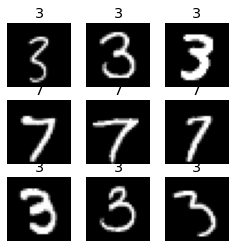

In [57]:
# define dataloaders
mnist = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    get_items=get_image_files,
                    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
                    get_y=parent_label)
dls = mnist.dataloaders(path, device=device)
# get a batch of data
dls.show_batch(max_n=9, figsize=(4,4))

In [59]:
first = next(iter(dls.valid))
first[0].shape, first[1].shape

(torch.Size([64, 3, 28, 28]), torch.Size([64]))

In [60]:
simple_net = nn.Sequential(
    # flatten the input
    nn.Flatten(1),
    nn.Linear(28*28*3,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [61]:
with torch.no_grad():
    print(simple_net(first[0]).shape)

torch.Size([64, 1])


In [72]:
nn.BCEWithLogitsLoss??

Init signature:
nn.BCEWithLogitsLoss(
    weight: Optional[torch.Tensor] = None,
    size_average=None,
    reduce=None,
    reduction: str = 'mean',
    pos_weight: Optional[torch.Tensor] = None,
) -> None
Source:        
class BCEWithLogitsLoss(_Loss):
    r"""This loss combines a `Sigmoid` layer and the `BCELoss` in one single
    class. This version is more numerically stable than using a plain `Sigmoid`
    followed by a `BCELoss` as, by combining the operations into one layer,
    we take advantage of the log-sum-exp trick for numerical stability.

    The unreduced (i.e. with :attr:`reduction` set to ``'none'``) loss can be described as:

    .. math::
        \ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
        l_n = - w_n \left[ y_n \cdot \log \sigma(x_n)
        + (1 - y_n) \cdot \log (1 - \sigma(x_n)) \right],

    where :math:`N` is the batch size. If :attr:`reduction` is not ``'none'``
    (default ``'mean'``), then

    .. math::
        \ell(x, y) = \begin{cases}
     

In [70]:
# train the model
def loss_fn(preds, targets):
    # cross entropy loss
    return nn.BCEWithLogitsLoss()(preds, targets.float().unsqueeze(-1))

def accuracy_fnc(preds, targets):
    return ((preds>0.5) == targets).float().mean()

learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=loss_fn,
                metrics=accuracy_fnc)


In [71]:
learn.fit_one_cycle(2, 0.1)

epoch,train_loss,valid_loss,accuracy_fnc,time
0,0.072351,0.063171,0.973319,00:24
1,0.050202,0.061760,0.973749,00:23


In [73]:
# print model stats
learn.model
# print number of parameters and ops/s
learn.summary()
total_params = sum(p.numel() for p in learn.model.parameters())
print(f'total parameters: {total_params}')
total_trainable_params = sum(p.numel() for p in learn.model.parameters() if p.requires_grad)
print(f'total trainable parameters: {total_trainable_params}')

total parameters: 70621
total trainable parameters: 70621


In [74]:
def conv(ni, nf, ks=3, act=True): 
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2) 
    if act: res = nn.Sequential(res, nn.ReLU()) 
    return res

In [78]:
# Question: How to name nn.Sequential layers?
# Answer: You can name the layers by passing a dictionary to the Sequential constructor.
#         The keys of the dictionary will be the names of the layers.
#         The names can be used to access the layers by name.
nn.Sequential??

Init signature: nn.Sequential(*args)
Source:        
class Sequential(Module):
    r"""A sequential container.
    Modules will be added to it in the order they are passed in the
    constructor. Alternatively, an ``OrderedDict`` of modules can be
    passed in. The ``forward()`` method of ``Sequential`` accepts any
    input and forwards it to the first module it contains. It then
    "chains" outputs to inputs sequentially for each subsequent module,
    finally returning the output of the last module.

    The value a ``Sequential`` provides over manually calling a sequence
    of modules is that it allows treating the whole container as a
    single module, such that performing a transformation on the
    ``Sequential`` applies to each of the modules it stores (which are
    each a registered submodule of the ``Sequential``).

    What's the difference between a ``Sequential`` and a
    :class:`torch.nn.ModuleList`? A ``ModuleList`` is exactly what it
    sounds like--a list for st

In [76]:
simple_cnn = nn.Sequential(
    conv(3, 8, ks=5), #14
    conv(8, 16), #7
    conv(16, 32), #4
    conv(32, 32), #2
    conv(32, 1, act=False), #1
    nn.Flatten()
)

In [88]:
simple_cnn = sequential( 
                        conv(3 ,4), #14x14 
                        conv(4 ,8), #7x7 
                        conv(8 ,16), #4x4 
                        conv(16,32), #2x2 
                        conv(32,1, act=False), #1x1 
                        Flatten(), )

In [89]:
with torch.no_grad():
    print(simple_cnn(first[0]).shape)

torch.Size([64, 1])


In [91]:
# train the model
# def loss_fn(preds, targets):
#     # cross entropy loss
#     return nn.BCEWithLogitsLoss()(preds, targets.float().unsqueeze(-1))
def loss_fn(preds, targets):
    # cross entropy loss
    return nn.CrossEntropyLoss()(preds, targets.float().unsqueeze(-1))

learn = Learner(dls, simple_cnn, opt_func=SGD,
                loss_func=loss_fn,
                metrics=accuracy_fnc)
learn.fit_one_cycle(2, 0.1)

epoch,train_loss,valid_loss,accuracy_fnc,time
0,0.000000,0.000000,0.495584,00:40
1,0.000000,0.000000,0.495584,00:42
